# Radial Velocity Measurement with a Trajectory Example

Simple example that uses pointwise radial velocity measurements to estimate body velocity of the vehicle, taking into account motion distortion.


In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 14,
})

np.set_printoptions(6, suppress=True)

from pylgmath import Transformation, se3op
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver
from pysteam.evaluable import se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.p2p import RadialVelErrorEvaluator

Problem: assuming the vehicle is moving w.r.t the inertial frame while getting radial velocity measurements to several landmark points, we want to estimate the body velocity of the vehicle. We restrict the problem to 2D. We consider that each measurement is acquired at a different time and use a constant velocity prior for velocity interpolation.

First, make up some ground truth data:

In [2]:
# Time horizon, consider this the time for getting a full lidar scan
T = 1

# The vehicle-inertial transformation at t=0, assuming to be identity for simplicity
T_iv = np.eye(4)
T_vi = npla.inv(T_iv)

# The sensor-vehicle transformation, assuming the sensor is 1 meter ahead of the vehicle.
T_vs = np.array([
    [1.0, 0.0, 0.0, 1.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
])
T_sv = npla.inv(T_vs)

# The ground truth body-velocity of the vehicle - the vehicle is moving forward (x-axis) while rotating (z-axis)
w_iv_inv = np.array([[-2.0, 0.0, 0.0, 0.0, 0.0, 0.8]]).T
w_is_ins = se3op.tranAd(T_sv) @ w_iv_inv  # transform to sensor frame

# The homogeneous coordinates of the landmarks in the inertial frame with timestamp being measured
lm_ini = [
    (0.25 * T, np.array([[0.0, 2.0, 0.0, 1.0]]).T),
    (0.5 * T, np.array([[2.0, 0.0, 0.0, 1.0]]).T),
    (0.75 * T, np.array([[0.0, -2.0, 0.0, 1.0]]).T),
]

## Generate ground truth radial velocity measurements
# transform landmark to sensor frame (taking into account their timestamp)
lm_ins = [(t, T_sv @ se3op.vec2tran(t * w_iv_inv) @ T_vi @ lm) for t, lm in lm_ini]
# compute velocity of landmarks in sensor frame
dot_lm_ins = [(t, se3op.point2fs(lm) @ w_is_ins) for t, lm in lm_ins]
# compute ground truth radial velocity measurements
D = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
])  # projection matrix to remove the last element of a homogeneous point
rv_measurements = [(t, (lm.T @ D.T @ D @ dot_lm) / np.sqrt(lm.T @ D.T @ D @ lm)) for (t, dot_lm), (_, lm) in zip(dot_lm_ins, lm_ins)]


Now, we use the radial velocity measurements to estimate the body velocity of the vehicle. Let's setup the optimization problem:

In [3]:
## setup trajectory
# state variables
T_sv_var = SE3StateVar(Transformation(T_ba=T_sv), locked=True)  # sensor-vehicle transformation - this is fixed
T_vi_at0_var = SE3StateVar(Transformation(T_ba=T_vi), locked=True)  # vehicle pose at t=0, fixed
w_iv_inv_at0_var = VSpaceStateVar(np.zeros((6, 1)))  # vehicle velocity at t=0, to be estimated
T_vi_atT_var = SE3StateVar(Transformation(T_ba=T_vi))  # vehicle pose at t=0, to be estimated
w_iv_inv_atT_var = VSpaceStateVar(np.zeros((6, 1)))  # vehicle velocity at t=0
# trajectory interface
qcd = np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])
traj = TrajectoryInterface(qcd=qcd)
traj.add_knot(time=Time(0), T_k0=T_vi_at0_var, w_0k_ink=w_iv_inv_at0_var)
traj.add_knot(time=Time(T), T_k0=T_vi_atT_var, w_0k_ink=w_iv_inv_atT_var)

## radial velocity measurement cost terms
noise_model = StaticNoiseModel(np.eye(1))
loss_func = L2LossFunc()
meas_cost_terms = []
for (t, lm), (_, rv) in zip(lm_ins, rv_measurements):
  w_iv_inv_att_eval = traj.get_velocity_interpolator(Time(secs=t))
  w_is_ins_eval = se3ev.compose_velocity(T_sv_var, w_iv_inv_att_eval)
  rv_error = RadialVelErrorEvaluator(w_is_ins_eval, lm[:3], rv[0, 0])
  meas_cost_terms.append(WeightedLeastSquareCostTerm(rv_error, noise_model, loss_func))

# the problem is not well-constrained, we need to add a prior. This prior below encourages the velocity to be zero. It
#   1. penalizes translational velocity along z-axis and rotational velocity along x-axis and y-axis - since the problem is 2D
#   2. penalizes translational velocity along y-axis more than x-axis - so that we converge to the correct solution
prior_w_iv_inv_at0 = np.zeros((6, 1))
cov = np.diag([1e4, 1e-2, 1e-2, 1e-2, 1e-2, 1e4])
traj.add_velocity_prior(Time(0), prior_w_iv_inv_at0, cov)

opt_prob = OptimizationProblem()
opt_prob.add_state_var(w_iv_inv_at0_var, T_vi_atT_var, w_iv_inv_atT_var)
opt_prob.add_cost_term(*meas_cost_terms, *traj.get_prior_cost_terms())

gauss_newton = GaussNewtonSolver(opt_prob, verbose=True, max_iterations=100)
gauss_newton.optimize()

print("Ground truth body velocity is:", w_iv_inv.flatten())
print("Estimated body velocity is:", w_iv_inv_atT_var.evaluate().flatten())

Begin Optimization
------------------
Number of States:  3
Number of Cost Terms:  5
Initial Cost:  2.7651746996637807
Iteration:    1  -  Cost:     0.0002
Iteration:    2  -  Cost:     0.0002
Termination Cause:  CONVERGED ABSOLUTE CHANGE
Ground truth body velocity is: [-2.   0.   0.   0.   0.   0.8]
Estimated body velocity is: [-1.999755 -0.000034  0.        0.        0.        0.799968]


Now we plot the initial, interpolated and final vehicle pose in 2D according to the ground truth/estimated body velocity. They should match.

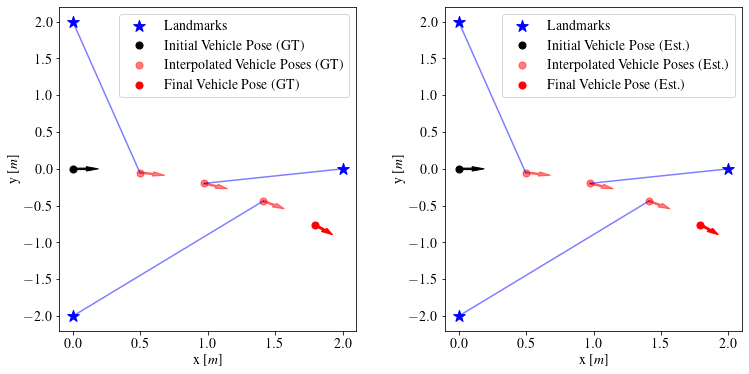

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)

lm_ini_x = [lm[0, 0] for _, lm in lm_ini]
lm_ini_y = [lm[1, 0] for _, lm in lm_ini]

# ground truth
axs[0].scatter(lm_ini_x, lm_ini_y, marker='*', color='b', s=150, label='Landmarks')
# plot initial pose
axs[0].scatter(T_iv[0, 3], T_iv[1, 3], marker='o', color='k', s=50, label='Initial Vehicle Pose (GT)')
axs[0].arrow(T_iv[0, 3], T_iv[1, 3], T_iv[0, 0]/10, T_iv[1, 0]/10, width=0.02, color='k')
for i, (t, lm) in enumerate(lm_ini):
  T_vi_att = se3op.vec2tran(t * w_iv_inv) @ T_vi
  T_iv_att = npla.inv(T_vi_att)
  axs[0].scatter(T_iv_att[0, 3], T_iv_att[1, 3], marker='o', color='r', s=50, alpha=0.5, label="Interpolated Vehicle Poses (GT)" if i==0 else None)
  axs[0].arrow(T_iv_att[0, 3], T_iv_att[1, 3], T_iv_att[0, 0]/10, T_iv_att[1, 0]/10, width=0.02, color='r', alpha=0.5)
  axs[0].plot([T_iv_att[0, 3], lm[0, 0]], [T_iv_att[1, 3], lm[1, 0]], 'b', alpha=0.5)
# plot final pose
T_vi_atT = se3op.vec2tran(T * w_iv_inv) @ T_vi
T_iv_atT = npla.inv(T_vi_atT)
axs[0].scatter(T_iv_atT[0, 3], T_iv_atT[1, 3], marker='o', color='r', s=50, label='Final Vehicle Pose (GT)')
axs[0].arrow(T_iv_atT[0, 3], T_iv_atT[1, 3], T_iv_atT[0, 0]/10, T_iv_atT[1, 0]/10, width=0.02, color='r')

axs[0].legend()
axs[0].set_xlabel('x [$m$]')
axs[0].set_ylabel('y [$m$]')

## estimated
axs[1].scatter(lm_ini_x, lm_ini_y, marker='*', color='b', s=150, label='Landmarks')
# plot initial pose
T_vi_at0 = traj.get_pose_interpolator(Time(0)).evaluate().matrix()
T_iv_at0 = npla.inv(T_vi_at0)
axs[1].scatter(T_iv_at0[0, 3], T_iv_at0[1, 3], marker='o', color='k', s=50, label='Initial Vehicle Pose (Est.)')
axs[1].arrow(T_iv_at0[0, 3], T_iv_at0[1, 3], T_iv_at0[0, 0]/10, T_iv_at0[1, 0]/10, width=0.02, color='k')
# plot interpolated poses with their associated measurements
for i, (t, lm) in enumerate(lm_ini):
  T_vi_att = traj.get_pose_interpolator(Time(t)).evaluate().matrix()
  T_iv_att = npla.inv(T_vi_att)
  axs[1].scatter(T_iv_att[0, 3], T_iv_att[1, 3], marker='o', color='r', s=50, alpha=0.5, label="Interpolated Vehicle Poses (Est.)" if i==0 else None)
  axs[1].arrow(T_iv_att[0, 3], T_iv_att[1, 3], T_iv_att[0, 0]/10, T_iv_att[1, 0]/10, width=0.02, color='r', alpha=0.5)
  axs[1].plot([T_iv_att[0, 3], lm[0, 0]], [T_iv_att[1, 3], lm[1, 0]], 'b', alpha=0.5)
# plot final pose
T_vi_atT = traj.get_pose_interpolator(Time(T)).evaluate().matrix()
T_iv_atT = npla.inv(T_vi_atT)
axs[1].scatter(T_iv_atT[0, 3], T_iv_atT[1, 3], marker='o', color='r', s=50, label='Final Vehicle Pose (Est.)')
axs[1].arrow(T_iv_atT[0, 3], T_iv_atT[1, 3], T_iv_atT[0, 0]/10, T_iv_atT[1, 0]/10, width=0.02, color='r')

axs[1].legend()
axs[1].set_xlabel('x [$m$]')
axs[1].set_ylabel('y [$m$]')
plt.show()